# Contextual Bayesian Optimisation via Large Language Models

This notebook will implement constrained dynamic prompt engineering via ensemble feature selection and prefix adaptation. The output of this process will then be used in Part 2.

<DIV STYLE="background-color:#000000; height:10px; width:100%;">

# Import Libraries

In [1]:
# Standard Library
import matplotlib.pyplot as plt

# Third Party
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
# Seed results
np.random.seed(0)

# Data Preparation

The original paper used data corresponding to this paper [ESOL](https://www.researchgate.net/publication/8551133_ESOL_Estimating_Aqueous_Solubility_Directly_from_Molecular_Structure) - this corresponds to only 927 examples with 7 columns, with only 3 being important. This is not enough information for us to compare alternative techniques, hence we will use the larger dataset, provided from Kaggle, which incorporates more information about these molecules [AqSOL](https://www.kaggle.com/datasets/sorkun/aqsoldb-a-curated-aqueous-solubility-dataset?resource=download).

In [4]:
# Establish path to full solubility data (from Aqsol databse)
aqsoldb_df = pd.read_csv("../../Code/paper/data/full_solubility.csv")

In [5]:
# Clean
aqsoldb_df = aqsoldb_df.dropna()
aqsoldb_df = aqsoldb_df.drop_duplicates().reset_index(drop=True)
aqsoldb_df.rename(columns={"Name": "Compound ID"}, inplace=True)
aqsoldb_df = aqsoldb_df.drop(["ID"], axis=1)

Given the token length of the OpenAI language models, we will work with chemical compounds which have a length of less than 15.

In [6]:
# Keep compounds that "read" easily
aqsoldb_df = aqsoldb_df[aqsoldb_df["Compound ID"].str.len() < 15].reset_index(drop=True)
aqsoldb_df

,Compound ID,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,MolLogP,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,vinyltoluene,"InChI=1S/C9H10/c1-3-9-6-4-5-8(2)7-9/h3-7H,1H2,2H3",JZHGRUMIRATHIU-UHFFFAOYSA-N,Cc1cccc(C=C)c1,-3.123150,0.000000,1,G1,118.179,2.63802,...,1.0,46.0,1.0,0.0,0.0,1.0,0.00,55.836626,3.070761,211.033225
1,hydroxylamine,"InChI=1S/H3NO/c1-2/h2H,1H2",AVXURJPOCDRRFD-UHFFFAOYSA-N,NO,-0.763034,0.861298,7,G4,33.030,-0.66570,...,0.0,14.0,0.0,0.0,0.0,0.0,46.25,12.462472,1.000000,2.000000
2,molybdenum,InChI=1S/Mo,ZOKXTWBITQBERF-UHFFFAOYSA-N,[Mo],-4.203848,0.000000,1,G1,95.940,-0.00250,...,0.0,6.0,0.0,0.0,0.0,0.0,0.00,21.756566,0.000000,0.000000
3,Prednisolone,InChI=1S/C21H28O5/c1-19-7-5-13(23)9-12(19)3-4-...,OIGNJSKKLXVSLS-VWUMJDOOSA-N,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)C=C[C@...,-3.178447,0.015047,2,G3,360.450,1.55760,...,2.0,142.0,0.0,3.0,4.0,4.0,94.83,153.341308,1.747281,723.913082
4,fluoromethane,InChI=1S/CH3F/c1-2/h1H3,NBVXSUQYWXRMNV-UHFFFAOYSA-N,CF,-0.175874,0.000000,1,G1,34.033,0.58570,...,0.0,14.0,0.0,0.0,0.0,0.0,0.00,12.904786,1.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888,tetracaine,InChI=1S/C15H24N2O2/c1-4-5-10-16-14-8-6-13(7-9...,GKCBAIGFKIBETG-UHFFFAOYSA-N,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000,0.000000,1,G1,264.369,2.61700,...,8.0,106.0,1.0,0.0,0.0,1.0,41.57,115.300645,2.394548,374.236893
1889,tetracycline,InChI=1S/C22H24N2O8/c1-21(31)8-5-4-6-11(25)12(...,OFVLGDICTFRJMM-WESIUVDSSA-N,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000,0.000000,1,G1,444.440,-0.21440,...,2.0,170.0,1.0,0.0,3.0,4.0,181.62,182.429237,2.047922,1148.584975
1890,thymol,InChI=1S/C10H14O/c1-7(2)9-5-4-8(3)6-10(9)11/h4...,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000,0.019222,3,G5,150.221,2.82402,...,1.0,60.0,1.0,0.0,0.0,1.0,20.23,67.685405,3.092720,251.049732
1891,verapamil,"InChI=1S/C27H38N2O4/c1-20(2)27(19-28,22-10-12-...",SGTNSNPWRIOYBX-UHFFFAOYSA-N,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000,0.000000,1,G1,454.611,5.09308,...,13.0,180.0,2.0,0.0,0.0,2.0,63.95,198.569223,2.023333,938.203977


# Feature Selection

## Correlation

Pearson or Spearman correlation coefficients can be used to measure the linear relationship between each feature and the target variable. Features with a higher absolute correlation coefficient have more predictive power.
Note that correlation does not imply causation and this does not take into account interactive relationships.

In [59]:
# Keep columns to check correlation
cols_to_keep = []
for i in range(len(aqsoldb_df.columns)):
    if (
        aqsoldb_df.dtypes[aqsoldb_df.columns[i]] == "int64"
        or aqsoldb_df.dtypes[aqsoldb_df.columns[i]] == "float64"
    ):
        cols_to_keep.append(aqsoldb_df.columns[i])
compound_df = aqsoldb_df["Compound ID"]
features_df = aqsoldb_df[cols_to_keep]
compound_df, features_df

(0        vinyltoluene
 1       hydroxylamine
 2          molybdenum
 3        Prednisolone
 4       fluoromethane
             ...      
 1888       tetracaine
 1889     tetracycline
 1890           thymol
 1891        verapamil
 1892         warfarin
 Name: Compound ID, Length: 1893, dtype: object,
       Solubility        SD  Ocurrences    MolWt  MolLogP     MolMR  \
 0      -3.123150  0.000000           1  118.179  2.63802   41.2700   
 1      -0.763034  0.861298           7   33.030 -0.66570    5.9739   
 2      -4.203848  0.000000           1   95.940 -0.00250    0.0000   
 3      -3.178447  0.015047           2  360.450  1.55760   95.0484   
 4      -0.175874  0.000000           1   34.033  0.58570    7.0320   
 ...          ...       ...         ...      ...      ...       ...   
 1888   -3.010000  0.000000           1  264.369  2.61700   78.6762   
 1889   -2.930000  0.000000           1  444.440 -0.21440  109.5409   
 1890   -2.190000  0.019222           3  150.221  2.82402  

In [60]:
# Standardise data
features_df = (features_df - features_df.mean(axis=0)) / features_df.std(ddof=0)

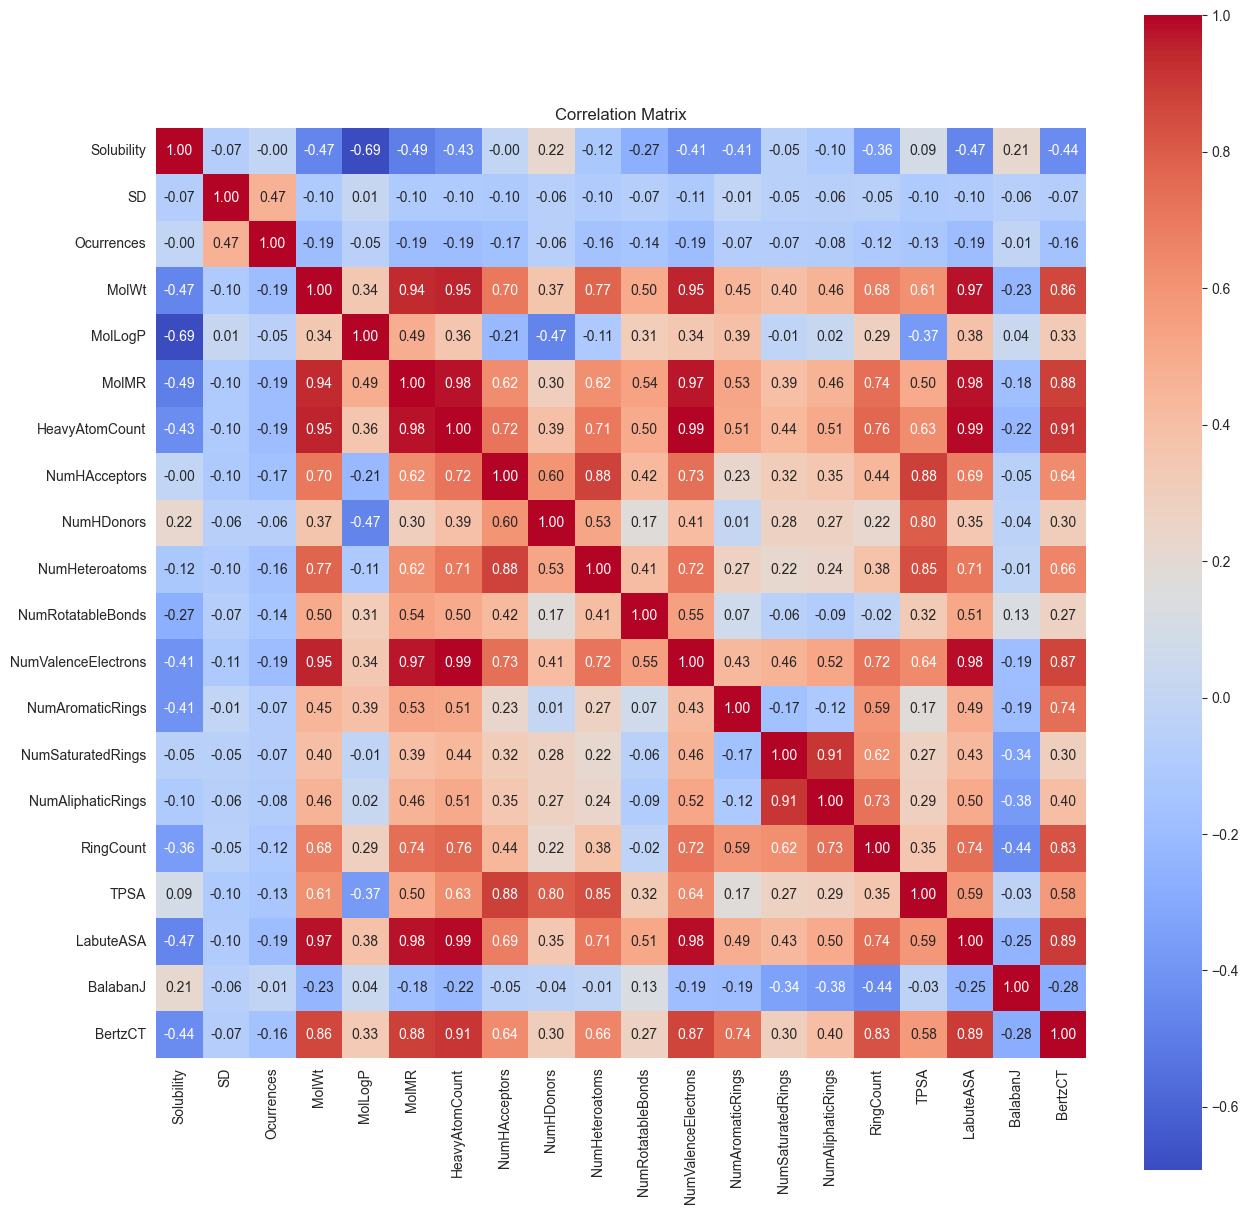

In [61]:
# Calculate correlation matrix
correlation_matrix = features_df.corr()
# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [62]:
# Get the correlation values with the target variable
correlation_with_target = correlation_matrix.iloc[0, 1:]
# Get the absolute correlation values
absolute_correlation_with_target = correlation_with_target.abs()
# Sort the values in descending order
sorted_correlation = absolute_correlation_with_target.sort_values(ascending=False)
print(f"The ordered feature importance is: {list(sorted_correlation.index)}")

The ordered feature importance is: ['MolLogP', 'MolMR', 'LabuteASA', 'MolWt', 'BertzCT', 'HeavyAtomCount', 'NumAromaticRings', 'NumValenceElectrons', 'RingCount', 'NumRotatableBonds', 'NumHDonors', 'BalabanJ', 'NumHeteroatoms', 'NumAliphaticRings', 'TPSA', 'SD', 'NumSaturatedRings', 'Ocurrences', 'NumHAcceptors']


## Mutual Information

Mutual Information (MI) between two variables is a measure of the amount of information that knowing the value of one of the variables provides about the other. Unlike correlation, mutual information can capture any kind of dependency between variables, not only linear relationships.

In [63]:
# Calculate mutual information
mi = mutual_info_regression(features_df.iloc[:, 1:], features_df.iloc[:, 0])
# Create a Series with the results
mi_series = pd.Series(mi, index=list(features_df.columns)[1:])
# Sort the values in descending order
sorted_mi = mi_series.sort_values(ascending=False)
print(f"The ordered feature importance is: {list(sorted_mi.index)}")

The ordered feature importance is: ['MolLogP', 'MolMR', 'MolWt', 'LabuteASA', 'NumValenceElectrons', 'HeavyAtomCount', 'BertzCT', 'NumHeteroatoms', 'NumAromaticRings', 'RingCount', 'BalabanJ', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds', 'NumHDonors', 'NumAliphaticRings', 'NumSaturatedRings', 'SD', 'Ocurrences']


## Model

We can obtain feature importances from training different models on the dataset. These are (non-exhaustive):
1. Internal feature importance e.g. parameter co-efficients.
2. Permutation importance.
3. Partial Dependence Plot

In [64]:
# Feature Importance Optimising Machine Learning Framework
class FIOptML:
    def __init__(self, features, target, cv, n_trials):
        self.features = features
        self.target = target.squeeze()
        self.cv = cv
        self.n_trials = n_trials

    def objective_linreg(self, trial):
        model = LinearRegression()
        scores = cross_val_score(model, self.features, self.target, cv=self.cv)
        return np.mean(scores)

    def objective_xgb(self, trial):
        n_estimators = trial.suggest_int("n_estimators", 100, 500)
        learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
        max_depth = trial.suggest_int("max_depth", 3, 10)
        model = xgb.XGBRegressor(
            n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth
        )
        scores = cross_val_score(model, self.features, self.target, cv=self.cv)
        return np.mean(scores)

    def objective_mlp(self, trial):
        hidden_layer_sizes = trial.suggest_categorical(
            "hidden_layer_sizes", [(50,), (100,), (200,)]
        )
        alpha = trial.suggest_loguniform("alpha", 1e-5, 1e0)
        learning_rate_init = trial.suggest_loguniform("learning_rate_init", 1e-4, 1e0)
        model = MLPRegressor(
            hidden_layer_sizes=hidden_layer_sizes,
            alpha=alpha,
            learning_rate_init=learning_rate_init,
        )
        scores = cross_val_score(model, self.features, self.target, cv=self.cv)
        return np.mean(scores)

    def get_optimized_model(self, model_name):
        if model_name.lower() == "lr":
            study = optuna.create_study(direction="maximize")
            study.optimize(self.objective_linreg, n_trials=self.n_trials)
            model = LinearRegression()
            model.fit(self.features, self.target)
            result = permutation_importance(
                model, self.features, self.target, n_repeats=3
            )
            return model, result.importances_mean
        elif model_name.lower() == "xgb":
            study = optuna.create_study(direction="maximize")
            study.optimize(self.objective_xgb, n_trials=self.n_trials)
            model = xgb.XGBRegressor(**study.best_params)
            model.fit(self.features, self.target)
            return model, model.feature_importances_
        elif model_name.lower() == "mlp":
            study = optuna.create_study(direction="maximize")
            study.optimize(self.objective_mlp, n_trials=self.n_trials)
            model = MLPRegressor(**study.best_params)
            model.fit(self.features, self.target)
            result = permutation_importance(
                model, self.features, self.target, n_repeats=3
            )
            return model, result.importances_mean
        else:
            raise ValueError("Model not in pipeline framework!")

In [65]:
# Instantiate framework
pipeline_fi = FIOptML(
    features=features_df.iloc[:, 1:], target=features_df.iloc[:, 0], cv=3, n_trials=5
)
# Run all models
results = dict()
model_names = ["lr", "xgb", "mlp"]
# Loop through models
for model_name in model_names:
    ret_1, ret_2 = pipeline_fi.get_optimized_model(model_name=model_name)
    results[model_name] = [ret_1, ret_2]

[I 2023-07-31 19:40:23,175] A new study created in memory with name: no-name-c1af934a-9541-400c-bd43-61c56c8ac91d
[I 2023-07-31 19:40:23,232] Trial 0 finished with value: 0.527478789199733 and parameters: {}. Best is trial 0 with value: 0.527478789199733.
[I 2023-07-31 19:40:23,253] Trial 1 finished with value: 0.527478789199733 and parameters: {}. Best is trial 0 with value: 0.527478789199733.
[I 2023-07-31 19:40:23,277] Trial 2 finished with value: 0.527478789199733 and parameters: {}. Best is trial 0 with value: 0.527478789199733.
[I 2023-07-31 19:40:23,300] Trial 3 finished with value: 0.527478789199733 and parameters: {}. Best is trial 0 with value: 0.527478789199733.
[I 2023-07-31 19:40:23,322] Trial 4 finished with value: 0.527478789199733 and parameters: {}. Best is trial 0 with value: 0.527478789199733.
[I 2023-07-31 19:40:23,399] A new study created in memory with name: no-name-e01db1f3-c6dd-473d-99e9-5903221caee7
/var/folders/lk/nt7ymd8953j6ryfm2zmz2g740000gn/T/ipykernel_355

In [68]:
# See results
results_df = pd.DataFrame(columns=["lr", "xgb", "mlp"])
for i, (key, value) in enumerate(results.items()):
    # Feature importance values
    fi_series = pd.Series(value[1], index=list(features_df.columns)[1:])
    # Print ordered importances
    results_df[model_names[i]] = fi_series
# Rank the features in terms of importances
selected_features_model = pd.DataFrame(
    results_df.rank(ascending=False).mean(axis=1).sort_values(ascending=True),
    columns=["Overall Rank"],
)
selected_features_model

,Overall Rank
MolLogP,3.000000
MolMR,3.000000
NumValenceElectrons,4.666667
MolWt,6.000000
BertzCT,7.000000
NumAromaticRings,8.000000
LabuteASA,8.333333
RingCount,8.333333
NumHeteroatoms,8.333333
NumAliphaticRings,8.333333


## Recursive Feature Elimination

This is a wrapper method that uses machine learning model performance to evaluate the importance of features. It removes the least important features one by one and re-trains the model until a specified number of features are left.

In [69]:
# Number of features to select
n_features_to_select = 5
# Create the RFE model and select n features
rfe = RFE(
    estimator=RandomForestRegressor(
        n_estimators=325, max_depth=20, min_samples_split=2
    ),
    n_features_to_select=n_features_to_select,
)
rfe = rfe.fit(features_df.iloc[:, 1:], features_df.iloc[:, 0])
# Summarize the selection of the attributes
selected_features_rfe = pd.DataFrame(
    {"Feature": list(features_df.columns)[1:], "Ranking": rfe.ranking_}
)
selected_features_rfe = selected_features_rfe.sort_values(by="Ranking")

Given the token lengths of the models as before, we will not exceed having more than 2 additional features in the prompt templates (with 1 being the compound name). From all the feature selection techniques, we have:

In [70]:
# Accumulate top 5 features
num_features = 5
final_features_df = pd.DataFrame(
    columns=["Correlation", "Mutual Information", "Model", "RFE"]
)
final_features_df["Correlation"] = list(sorted_correlation.index)[:num_features]
final_features_df["Mutual Information"] = list(sorted_mi.index)[:num_features]
final_features_df["Model"] = list(selected_features_model.index)[:num_features]
final_features_df["RFE"] = list(selected_features_rfe["Feature"])[:num_features]
final_features_df

,Correlation,Mutual Information,Model,RFE
0,MolLogP,MolLogP,MolLogP,BertzCT
1,MolMR,MolMR,MolMR,MolWt
2,LabuteASA,MolWt,NumValenceElectrons,MolLogP
3,MolWt,LabuteASA,MolWt,MolMR
4,BertzCT,NumValenceElectrons,BertzCT,TPSA


<DIV STYLE="background-color:#000000; height:10px; width:100%;">